Analysing with Decision tree
Setup: put it in the same folder as "unifed_csv_without_duplicated_company.csv" and "ROI.csv" (generated by get_roi notebook) 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split   
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.model_selection import GridSearchCV

# Optional
# import library for visuaiization
from sklearn import tree
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
#Read both CSV
df=pd.read_csv("unifed_csv_without_duplicated_company.csv")
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37198 entries, 0 to 37197
Data columns (total 132 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   company_uuid                      37198 non-null  object 
 1   country_code                      33609 non-null  object 
 2   region                            33609 non-null  object 
 3   city                              33609 non-null  object 
 4   operating                         37198 non-null  int64  
 5   closed                            37198 non-null  int64  
 6   success                           37198 non-null  int64  
 7   success_acquired                  37198 non-null  int64  
 8   success_ipo                       37198 non-null  int64  
 9   num_funding_rounds                12036 non-null  float64
 10  total_funding_usd                 9093 non-null   float64
 11  founded_on                        37198 non-null  float64
 12  las

In [3]:
#Create dataframe for features
features=df[["company_uuid", "operating","closed","success","success_acquired","success_ipo", "num_funding_rounds","Financial Services","FinTech","Finance","Blockchain", "Information Technology", "Software",  "Payments" , "Cryptocurrency", "Venture Capital","Internet", "Banking", "Consulting",  "Mobile Payments","E-Commerce", "Insurance", "Bitcoin", "Artificial Intelligence", "Mobile", "Crowdfunding","SaaS",  "Real Estate", "Apps", "Personal Finance","Accounting", "Mobile Apps", "Asset Management", "Marketplace", "Lending", "Big Data", "Machine Learning", "gender_male", "gender_female" ]].copy()
dummy= df.columns[70:]
dummy_df= df[dummy]
features= features.join(dummy_df)
features.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37198 entries, 0 to 37197
Data columns (total 101 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   company_uuid                     37198 non-null  object 
 1   operating                        37198 non-null  int64  
 2   closed                           37198 non-null  int64  
 3   success                          37198 non-null  int64  
 4   success_acquired                 37198 non-null  int64  
 5   success_ipo                      37198 non-null  int64  
 6   num_funding_rounds               12036 non-null  float64
 7   Financial Services               37198 non-null  int64  
 8   FinTech                          37198 non-null  int64  
 9   Finance                          37198 non-null  int64  
 10  Blockchain                       37198 non-null  int64  
 11  Information Technology           37198 non-null  int64  
 12  Software         

In [4]:
features= features.drop(columns=["time_in_year","investment_delta", "norm_amount_delta", "momentum", "max_norm_amount_delta", "roi_from_mean_momentum", "continent", "ROI" ])

In [5]:
for i in features.columns: 
    x= features[i].value_counts()
    print("column: ",i,", value is:",x)
    print()

column:  company_uuid , value is: b6768d21-8e56-46a9-9e8f-b657ddc972e6    1
6e9d02f4-8269-6a63-e7fd-d93bba151537    1
1a905cb0-15ce-49bd-a873-823f768c45db    1
98533cc9-cfbd-4d80-bb5f-09fc39261e10    1
b4f972d5-c4c5-4abe-ba7d-8b56ed77114c    1
                                       ..
71f18549-37d7-d8fb-087f-9e8834b2bf07    1
4867340d-1f2f-44b8-adde-2702657a3e9a    1
570787b9-4095-d92f-a1f9-fa7be44bf8fd    1
d5d6e9f4-5454-1e73-4be0-0d119eb5ef3b    1
831e5c4a-d0ba-4954-a6e4-9d4bf90f594f    1
Name: company_uuid, Length: 37198, dtype: int64

column:  operating , value is: 1    34671
0     2527
Name: operating, dtype: int64

column:  closed , value is: 0    36130
1     1068
Name: closed, dtype: int64

column:  success , value is: 0    35739
1     1459
Name: success, dtype: int64

column:  success_acquired , value is: 0    36071
1     1127
Name: success_acquired, dtype: int64

column:  success_ipo , value is: 0    36866
1      332
Name: success_ipo, dtype: int64

column:  num_funding_rounds

In [6]:
#Deal with null value in num_funding_rounds 
features["num_funding_rounds"]=features["num_funding_rounds"].fillna(0)

In [7]:
# Join with ROI.csv from ROI.ipynb
features["mean_norm_amount_delta"]=features["mean_norm_amount_delta"].fillna(0)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37198 entries, 0 to 37197
Data columns (total 93 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   company_uuid                     37198 non-null  object 
 1   operating                        37198 non-null  int64  
 2   closed                           37198 non-null  int64  
 3   success                          37198 non-null  int64  
 4   success_acquired                 37198 non-null  int64  
 5   success_ipo                      37198 non-null  int64  
 6   num_funding_rounds               37198 non-null  float64
 7   Financial Services               37198 non-null  int64  
 8   FinTech                          37198 non-null  int64  
 9   Finance                          37198 non-null  int64  
 10  Blockchain                       37198 non-null  int64  
 11  Information Technology           37198 non-null  int64  
 12  Software          

In [8]:
# define independent variables/attirbutes/features
x = features.drop(columns=['mean_norm_amount_delta', "company_uuid"])
y = features["mean_norm_amount_delta"]

#Make "mean_norm_amount_delta" column 1/0
binary_labels = [0,1]
y = pd.qcut(y, 2, labels = binary_labels)
y

0        0
1        0
2        0
3        0
4        0
        ..
37193    0
37194    0
37195    0
37196    0
37197    1
Name: mean_norm_amount_delta, Length: 37198, dtype: category
Categories (2, int64): [0 < 1]

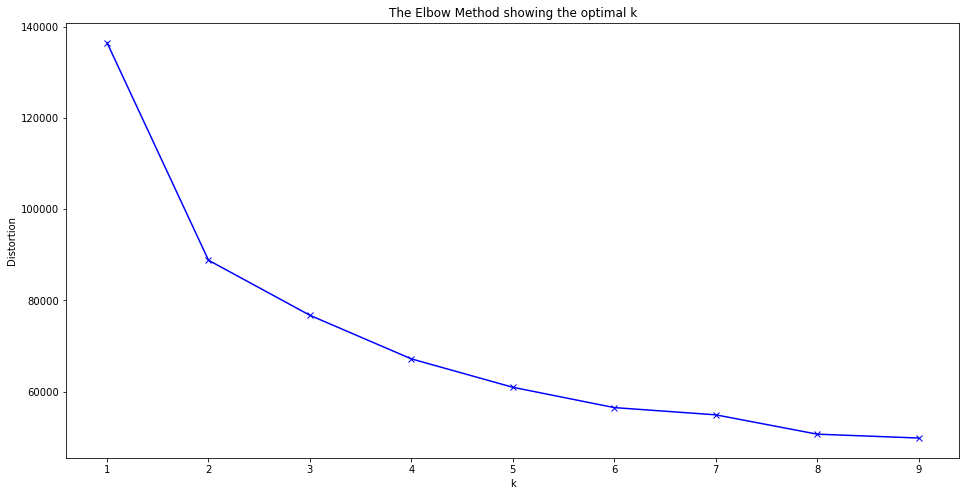

In [9]:
# Borrowed by Stardust to do elbow plot
from sklearn.cluster import KMeans
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

I recommend using k = 6 in trial models

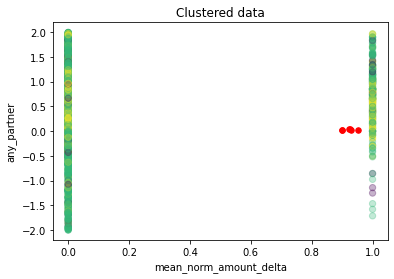

In [10]:
kmeans = KMeans(n_clusters=6).fit(x.astype(float))
centroids = kmeans.cluster_centers_
# centroids

plt.scatter(df['any_partner'], df['mean_norm_amount_delta'], c = kmeans.labels_.astype(float), s = 40, alpha = 0.3)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', s = 30)
plt.title("Clustered data")
plt.xlabel("mean_norm_amount_delta")
plt.ylabel("any_partner")
plt.show()
# This isn't a useful graph. Just put it here for later use

In [11]:
# Implement Decision tree
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5)
model=DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
# use the trained model to predict test set for evaluation
pred_test = model.predict(X_test)

# print out evaluation result
print("Accuracy:{}".format(accuracy_score(y_test, pred_test, normalize=True, sample_weight=None)))
print("Classification Report:\n{}".format(classification_report(y_test, pred_test)))
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, pred_test)))

Accuracy:0.943100358422939
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10303
           1       0.65      0.57      0.61       857

    accuracy                           0.94     11160
   macro avg       0.81      0.77      0.79     11160
weighted avg       0.94      0.94      0.94     11160

Confusion Matrix:
[[10033   270]
 [  365   492]]


In [33]:
#Visualize the tree

dot_data = tree.export_graphviz(model, 
                                out_file = None, 
                                feature_names = x.columns,  
                                class_names = ['Bad', 'Good'],
                                filled = True, 
                                rounded = True,  
                                special_characters = True)

graph = graphviz.Source(dot_data)  

graph

In [27]:
#Importance of features
x_col= x.columns
col=[]
importance= model.feature_importances_

for i in range(len(x_col)):
    str= x_col[i], importance[i]
    col.append(str )

col

[('operating', 0.0026857047702271803),
 ('closed', 0.0020723401831102975),
 ('success', 0.002275054399595642),
 ('success_acquired', 0.0019002078824136466),
 ('success_ipo', 0.0026243055049550486),
 ('num_funding_rounds', 0.8178368806184639),
 ('Financial Services', 0.004738393633491736),
 ('FinTech', 0.001983656654807784),
 ('Finance', 0.00022393974888291256),
 ('Blockchain', 0.0029425006532019966),
 ('Information Technology', 0.0),
 ('Software', 0.0),
 ('Payments', 0.0004124233164578476),
 ('Cryptocurrency', 0.0013363177448623554),
 ('Venture Capital', 0.0),
 ('Internet', 0.0),
 ('Banking', 0.0),
 ('Consulting', 0.0),
 ('Mobile Payments', 0.00036424895483490343),
 ('E-Commerce', 0.0),
 ('Insurance', 0.0),
 ('Bitcoin', 0.0002505811141843661),
 ('Artificial Intelligence', 0.0),
 ('Mobile', 0.0),
 ('Crowdfunding', 0.0),
 ('SaaS', 0.0),
 ('Real Estate', 0.0),
 ('Apps', 0.0),
 ('Personal Finance', 0.0),
 ('Accounting', 0.0),
 ('Mobile Apps', 0.0),
 ('Asset Management', 0.0),
 ('Marketplac

In [36]:
# Create a decision tree 

dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(model, out_file = dotfile, feature_names = x.columns)
dotfile.close()